Описание задачи
Цель:
Разделить изображение на несколько однородных регионов (объектов), используя метод спектральной кластеризации.

Используемый алгоритм:
Спектральная кластеризация (spectral_clustering)
Построение графа по пикселям изображения
Преобразование весов рёбер графа с использованием экспоненциальной функции
Источник данных:
Изображение coins.jpg — классическое изображение монет
Можно заменить на любое другое изображение в оттенках серого

Препроцессинг данных
На этом этапе мы:

Загружаем изображение
Преобразуем его в формат с плавающей точкой
Уменьшаем размер для ускорения вычислений
Применяем фильтр Гаусса для уменьшения шума
Преобразуем изображение в граф

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import io, img_as_float, transform
from scipy.ndimage import gaussian_filter
from sklearn.feature_extraction import image as sk_image
from sklearn.cluster import spectral_clustering
import time
import logging

# Настройка логирования
logging.basicConfig(level=logging.INFO, format="%(asctime)s [%(levelname)s] %(message)s")

In [2]:
# Загрузка изображения
logging.info("Загрузка изображения: coins.jpg")
img = img_as_float(io.imread("coins.jpg", as_gray=True))
logging.info(f"Изображение загружено. Форма: {img.shape}, dtype: {img.dtype}")

# Уменьшаем размер для ускорения
logging.info("Уменьшение размера изображения до 30%")
rescaled_img = transform.rescale(img, 0.3, anti_aliasing=True, mode="reflect")
logging.info(f"Размер изменён. Новая форма: {rescaled_img.shape}")

# Размываем немного, чтобы убрать шумы
logging.info("Применение фильтра Гаусса (sigma=1)")
smoothed_img = gaussian_filter(rescaled_img, sigma=1)
logging.info("Шумы сглажены")

# Преобразуем в граф
logging.info("Преобразование изображения в граф")
graph = sk_image.img_to_graph(smoothed_img)
logging.info(f"Граф построен. Количество рёбер: {len(graph.data)}")

# Настраиваем веса рёбер
logging.info("Настройка весов рёбер графа")
beta = 10
eps = 1e-6
graph.data = np.exp(-beta * graph.data / graph.data.std()) + eps
logging.info("Веса рёбер обновлены")

2025-05-15 00:31:04,356 [INFO] Загрузка изображения: coins.jpg
2025-05-15 00:31:04,398 [INFO] Изображение загружено. Форма: (1024, 1024), dtype: float64
2025-05-15 00:31:04,399 [INFO] Уменьшение размера изображения до 30%
2025-05-15 00:31:04,432 [INFO] Размер изменён. Новая форма: (307, 307)
2025-05-15 00:31:04,433 [INFO] Применение фильтра Гаусса (sigma=1)
2025-05-15 00:31:04,435 [INFO] Шумы сглажены
2025-05-15 00:31:04,436 [INFO] Преобразование изображения в граф
2025-05-15 00:31:04,457 [INFO] Граф построен. Количество рёбер: 470017
2025-05-15 00:31:04,458 [INFO] Настройка весов рёбер графа
2025-05-15 00:31:04,467 [INFO] Веса рёбер обновлены


Обучение модели
Применяется метод спектральной кластеризации к построенному графу.
Тестировались следующие методы присвоения меток:

kmeans
discretize
cluster_qr
Количество регионов задавалось вручную.

In [3]:
# Параметры
n_regions = 25
n_plus = 3
logging.info(f"Цель: выделить {n_regions} регионов")

2025-05-15 00:31:04,473 [INFO] Цель: выделить 25 регионов


In [4]:
# Применяем спектральную кластеризацию
results = {}

for assign_labels in ("kmeans", "discretize", "cluster_qr"):
    logging.info(f"Начинаем кластеризацию методом: {assign_labels}")
    t0 = time.time()

    labels = spectral_clustering(
        graph,
        n_clusters=n_regions + n_plus,
        eigen_tol=1e-7,
        assign_labels=assign_labels,
        random_state=42,
    )

    t1 = time.time()
    labels = labels.reshape(smoothed_img.shape)
    results[assign_labels] = (labels, t1 - t0)
    logging.info(f"Кластеризация завершена за {t1 - t0:.4f} сек.")

2025-05-15 00:31:04,479 [INFO] Начинаем кластеризацию методом: kmeans
2025-05-15 00:32:40,506 [INFO] Кластеризация завершена за 96.0265 сек.
2025-05-15 00:32:40,507 [INFO] Начинаем кластеризацию методом: discretize
2025-05-15 00:34:15,429 [INFO] Кластеризация завершена за 94.9200 сек.
2025-05-15 00:34:15,430 [INFO] Начинаем кластеризацию методом: cluster_qr
2025-05-15 00:35:49,675 [INFO] Кластеризация завершена за 94.2430 сек.


Визуализация
Результаты кластеризации отображаются в виде контуров вокруг сегментированных регионов.
Каждый регион окрашен в свой цвет для удобства восприятия.

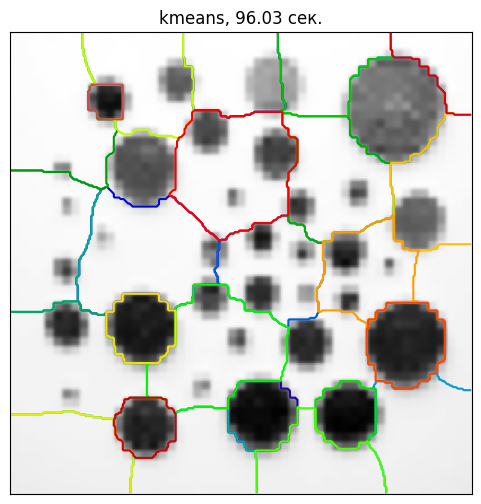

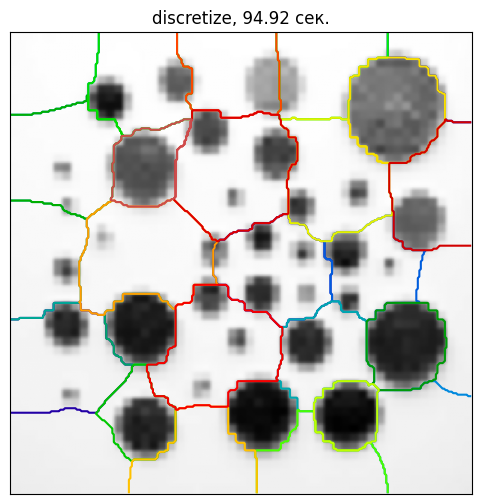

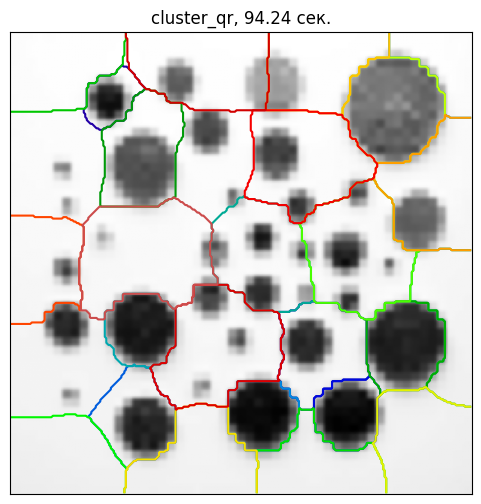

In [5]:
# Визуализация результатов
for method, (labels, duration) in results.items():
    plt.figure(figsize=(6, 6))
    plt.imshow(smoothed_img, cmap="gray")
    plt.title(f"{method}, {duration:.2f} сек.")
    plt.xticks([])
    plt.yticks([])

    for l in range(n_regions):
        colors = [plt.cm.nipy_spectral((l + 4) / float(n_regions + 4))]
        plt.contour(labels == l, colors=colors)
    plt.show()

Как выбрать лучший метод?
'kmeans' — стабильный, но может быть медленным
'discretize' — быстрее, но иногда менее точный
'cluster_qr' — экспериментальный, работает быстро, но чувствителен к параметрам
